<a href="https://colab.research.google.com/github/skywalker0803r/Microsoft-DAT257x-Reinforcement-Learning-Explained/blob/master/Ex1_3_Random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAT257x: Reinforcement Learning Explained

## Lab 1: Environments and Agents

### Exercise 3: Random Agent

Now that you have examine the SimpleRoomsEnv and CliffWalkingEnv environments in the Environments.py file, let's play around with an agent in those environments.

In [0]:
import numpy as np

### Interface
class Environment(object):

    def reset(self):
        raise NotImplementedError('Inheriting classes must override reset.')

    def actions(self):
        raise NotImplementedError('Inheriting classes must override actions.')

    def step(self):
        raise NotImplementedError('Inheriting classes must override step')

class ActionSpace(object):
    
    def __init__(self, actions):
        self.actions = actions
        self.n = len(actions)
        
### SimpleRoomsEnv Environment 

class SimpleRoomsEnv(Environment):
    """Define a simple 4-room environment"""
    """actions: 0 - north, 1 - east, 2 - west, 3 - south"""

    def __init__(self):
        super(SimpleRoomsEnv, self).__init__()

        # define state and action space
        self.S = range(16)
        self.action_space = ActionSpace(range(4))

        # define reward structure
        self.R = [0] * len(self.S)
        self.R[15] = 1
        
        # define transitions
        self.P = {}
        self.P[0] = [1, 4]
        self.P[1] = [0, 2, 5]
        self.P[2] = [1, 3, 6]
        self.P[3] = [2, 7]
        self.P[4] = [0, 5, 8]
        self.P[5] = [1, 4]
        self.P[6] = [2, 7]
        self.P[7] = [3, 6, 11]
        self.P[8] = [4, 9, 12]
        self.P[9] = [8, 13]
        self.P[10] = [11, 14]
        self.P[11] = [7, 10, 15]
        self.P[12] = [8, 13]
        self.P[13] = [9, 12, 14]
        self.P[14] = [10, 13, 15]
        self.P[15] = [11, 14]

        self.max_trajectory_length = 50
        self.tolerance = 0.1
        self._rendered_maze = self._render_maze()
        
    def step(self, action):
        s_prev = self.s
        self.s = self.single_step(self.s, action)
        reward = self.single_reward(self.s, s_prev, self.R)
        self.nstep += 1
        self.is_reset = False

        if (reward < -1. * (self.tolerance) or reward > self.tolerance) or self.nstep == self.max_trajectory_length:
            self.reset()

        return (self._convert_state(self.s), reward, self.is_reset, '')
    
    def single_step(self, s, a):
        if a < 0 or a > 3:
            raise ValueError('Unknown action', a)
        if a == 0 and (s-4 in self.P[s]):
            s -= 4
        elif a == 1 and (s+1 in self.P[s]):
            s += 1
        elif a == 2 and (s-1 in self.P[s]):
            s -= 1
        elif a == 3 and (s+4 in self.P[s]):
            s += 4
        return s

    def single_reward(self, s, s_prev, rewards):
        if s == s_prev:
            return 0
        return rewards[s]
    
    def reset(self):
        self.nstep = 0
        self.s = 0
        self.is_reset = True
        return self._convert_state(self.s)
    
    def _convert_state(self, s):
        converted = np.zeros(len(self.S), dtype=np.float32)
        converted[s] = 1
        return converted
    
    def _get_render_coords(self, s):
        return (int(s / 4) * 4, (s % 4) * 4)
    
    def _render_maze(self):
        # draw background and grid lines
        maze = np.zeros((17, 17))
        for x in range(0, 17, 4):
            maze[x, :] = 0.5
        for y in range(0, 17, 4):
            maze[:, y] = 0.5

        # draw reward and transitions
        for s in range(16):
            if self.R[s] != 0:
                x, y = self._get_render_coords(s)
                maze[x+1:x+4, y+1:y+4] = self.R[s]
            if self.single_step(s, 0) == s:
                x, y = self._get_render_coords(s)
                maze[x, y:y+5] = -1
            if self.single_step(s, 1) == s:
                x, y = self._get_render_coords(s)
                maze[x:x+5, y+4] = -1
            if self.single_step(s, 2) == s:
                x, y = self._get_render_coords(s)
                maze[x:x+5, y] = -1
            if self.single_step(s, 3) == s:
                x, y = self._get_render_coords(s)
                maze[x+4, y:y+4] = -1
        return maze

    def render(self, mode = 'rgb_array'):
        assert mode == 'rgb_array', 'Unknown mode: %s' % mode
        img = np.array(self._rendered_maze, copy=True)

        # draw current agent location
        x, y = self._get_render_coords(self.s)
        img[x+1:x+4, y+1:y+4] = 2.0
        return img

In [0]:
import numpy as np
import sys
from gym.envs.toy_text import discrete

### CliffWalkingEnv Environment 
    
class CliffWalkingEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi', 'rgb_array']}
    
    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta):
        new_position = np.array(current) + np.array(delta)
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        reward = -100.0 if self._cliff[tuple(new_position)] else -1.0
        is_done = self._cliff[tuple(new_position)] or (tuple(new_position) == (3,11))
        return [(1.0, new_state, reward, is_done)]

    def __init__(self):
        self.shape = (4, 12)

        nS = np.prod(self.shape)
        nA = 4

        # Cliff Location
        self._cliff = np.zeros(self.shape, dtype=np.bool)
        self._cliff[3, 1:-1] = True

        # Calculate transition probabilities
        P = {}
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = { a : [] for a in range(nA) }
            #UP = 0
            #RIGHT = 1
            #DOWN = 2
            #LEFT = 3
            P[s][0] = self._calculate_transition_prob(position, [-1, 0])
            P[s][1] = self._calculate_transition_prob(position, [0, 1])
            P[s][2] = self._calculate_transition_prob(position, [1, 0])
            P[s][3] = self._calculate_transition_prob(position, [0, -1])

        # We always start in state (3, 0)
        isd = np.zeros(nS)
        isd[np.ravel_multi_index((3,0), self.shape)] = 1.0

        super(CliffWalkingEnv, self).__init__(nS, nA, P, isd)

    def _convert_state(self, state):
        converted = np.unravel_index(state, self.shape)
        return np.asarray(list(converted), dtype=np.float32)
    
    def reset(self):
        self.s = np.argmax(self.isd)
        return self._convert_state(self.s)
    
    def step(self, action):
        reward = self.P[self.s][action][0][2]
        done = self.P[self.s][action][0][3]
        info = {'prob':self.P[self.s][action][0][0]}
        self.s = self.P[self.s][action][0][1]
        return (self._convert_state(self.s), reward, done, info)
    
    def render(self, mode='rgb_array', close=False):
        if close:
            return

        if mode == 'rgb_array':
            maze = np.zeros((4, 12))
            maze[self._cliff] = -1
            maze[np.unravel_index(self.s, self.shape)] = 2.0
            maze[(3,11)] = 0.5
            img = np.array(maze, copy=True)
            return img
        
        else:
            outfile = StringIO() if mode == 'ansi' else sys.stdout

            for s in range(self.nS):
                position = np.unravel_index(s, self.shape)

                if self.s == s:
                    output = " x "
                elif position == (3,11):
                    output = " T "
                elif self._cliff[position]:
                    output = " C "
                else:
                    output = " o "

                if position[1] == 0:
                    output = output.lstrip() 
                if position[1] == self.shape[1] - 1:
                    output = output.rstrip() 
                    output += "\n"

                outfile.write(output)
            outfile.write("\n")

In [0]:
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards", "episode_running_variance"])
TimestepStats = namedtuple("Stats",["cumulative_rewards", "regrets"])

def plot_episode_stats(stats, smoothing_window=10, hideplot=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if hideplot:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if hideplot:
        plt.close(fig2)
    else:
        plt.show(fig2)

    return fig1, fig2

def plot_pgresults(stats, smoothing_window=20, hideplot=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if hideplot:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if hideplot:
        plt.close(fig2)
    else:
        plt.show(fig2)
       
    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_running_variance)
    plt.xlabel("Episode")
    plt.ylabel("Running Variance")
    plt.title("Running Variance over Time")
    if hideplot:
        plt.close(fig3)
    else:
        plt.show(fig3)
        
    # Plot time steps and episode number
    fig4 = plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(stats.episode_lengths)), np.cumsum(stats.episode_lengths))
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Episode Length")
    plt.title("Cumulative Episode Length over Time")
    if hideplot:
        plt.close(fig4)
    else:
        plt.show(fig4)

    return fig1, fig2, fig3, fig4

def plot_dqnresults(stats, smoothing_window=20, hideplot=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if hideplot:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if hideplot:
        plt.close(fig2)
    else:
        plt.show(fig2)
              
    # Plot time steps and episode number
    fig4 = plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(stats.episode_lengths)), np.cumsum(stats.episode_lengths))
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Episode Length")
    plt.title("Cumulative Episode Length over Time")
    if hideplot:
        plt.close(fig4)
    else:
        plt.show(fig4)

    return fig1, fig2, fig3, fig4

def plot_reward_regret(stats, smoothing_window=1, hideplot=False):
    # Plot the cumulative reward over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.cumulative_rewards)
    plt.xlabel("Timestep")
    plt.ylabel("Cumulative Reward")
    plt.title("Cumulative Reward over Timestep")
    if hideplot:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the regret over time
    fig2 = plt.figure(figsize=(10,5))
    plt.plot(stats.regrets)
    plt.xlabel("Timestep")
    plt.ylabel("Regret")
    plt.title("Regret over Timestep")
    if hideplot:
        plt.close(fig2)
    else:
        plt.show(fig2)
             
    return fig1, fig2   

def plot_arm_rewards(y, hideplot=False):
    
    N = len(y)
    x = range(N)
    width = 1/1.5
    
    fig1 = plt.figure(figsize=(10,5))
    plt.bar(x, y, width)
    
    plt.xlabel("Arm")
    plt.ylabel("Probability")
    plt.title("Arm's Reward Distribution")
    
    if hideplot:
        plt.close(fig1)
    else:
        plt.show(fig1)
             
    return fig1   

In [0]:
import numpy as np
import sys
from matplotlib import pyplot as plt
from matplotlib import pylab
import matplotlib.gridspec as gridspec

class Experiment(object):
    def __init__(self, env, agent):
        
        self.env = env
        self.agent = agent
        
        self.episode_length = np.array([0])
        self.episode_reward = np.array([0])
        
        self.fig = pylab.figure(figsize=(10, 5))
        gs = gridspec.GridSpec(2, 2)
        self.ax = pylab.subplot(gs[:, 0])
        self.ax.xaxis.set_visible(False)
        self.ax.yaxis.set_visible(False)
        
        if hasattr(self.env, '_cliff'): # Hardcode to nicely display grid for cliffwalkingenv
            self.ax.xaxis.set_visible(True)
            self.ax.yaxis.set_visible(True)
            self.ax.set_xticks(np.arange(-.5, 12, 1), minor=True);
            self.ax.set_yticks(np.arange(-.5, 4, 1), minor=True);
            self.ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
            
        if hasattr(self.env, 'winds'): # Hardcode to nicely display grid for windygridworldenv
            self.ax.xaxis.set_visible(True)
            self.ax.yaxis.set_visible(True)
            self.ax.set_xticks(np.arange(-.5, 10, 1), minor=True);
            self.ax.set_yticks(np.arange(-.5, 7, 1), minor=True);
            self.ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        
        self.ax1 = pylab.subplot(gs[0, 1])
        self.ax1.yaxis.set_label_position("right")
        self.ax1.set_ylabel('Length')
        
        self.ax1.set_xlim(0, max(10, len(self.episode_length)+1))
        self.ax1.set_ylim(0, 51)
        
        self.ax2 = pylab.subplot(gs[1, 1])
        self.ax2.set_xlabel('Episode')
        self.ax2.yaxis.set_label_position("right")
        self.ax2.set_ylabel('Reward')
        self.ax2.set_xlim(0, max(10, len(self.episode_reward)+1))
        self.ax2.set_ylim(0, 2)
        
        self.line, = self.ax1.plot(range(len(self.episode_length)),self.episode_length)
        self.line2, = self.ax2.plot(range(len(self.episode_reward)),self.episode_reward)
        
    def update_display_step(self):
        if not hasattr(self, 'imgplot'):
            self.imgplot = self.ax.imshow(self.env.render(mode='rgb_array'), interpolation='none', cmap='viridis')
        else:
            self.imgplot.set_data(self.env.render(mode='rgb_array'))
    
        self.fig.canvas.draw()
        
    def update_display_episode(self):  
        self.line.set_data(range(len(self.episode_length)),self.episode_length)
        self.ax1.set_xlim(0, max(10, len(self.episode_length)+1))
        self.ax1.set_ylim(0, max(self.episode_length)+1)
        
        self.line2.set_data(range(len(self.episode_reward)),self.episode_reward)
        self.ax2.set_xlim(0, max(10, len(self.episode_reward)+1))
        self.ax2.set_ylim(min(self.episode_reward)-1, max(self.episode_reward)+1)
        
        self.fig.canvas.draw()     
        
    def run_bandit(self, max_number_of_trials=1000, display_frequency=1):
        self.fig.clf()
        
        print("Distribution:", self.env.distribution, self.env.reward_parameters, flush = True)
        print("Optimal arm:", self.env.optimal_arm, flush = True)
        
        if self.env.distribution != "normal":
          plot_arm_rewards(self.env.reward_parameters)
        #else:
            #plotting.plot_arm_rewards(self.env.reward_parameters[0])
        
        stats = TimestepStats(
            cumulative_rewards=np.zeros(max_number_of_trials),
            regrets=np.zeros(max_number_of_trials))   
            
        cumulative_reward = 0.0
        cumulative_regret = 0.0
        
        for trial in range(max_number_of_trials):
            action = self.agent.act()
            
            _ , reward, done, _ = self.env.step(action)       
            self.agent.feedback(action, reward)
            cumulative_reward += reward

            gap = self.env.compute_gap(action)
            if action != self.env.optimal_arm:
                cumulative_regret += gap

            stats.cumulative_rewards[trial] = cumulative_reward
            stats.regrets[trial] = cumulative_regret

        print("--------------------------------------------------", flush = True)
        print("Policy:", self.agent.name, "\nAverage Reward:", cumulative_reward / max_number_of_trials, \
                "\nAverage Regret:", cumulative_regret / max_number_of_trials, flush = True)
        print("Arm pulls:", self.agent.total_counts, flush = True)
         
        plot_reward_regret(stats)
        
    def run_agent(self, max_number_of_episodes=100, interactive = False, display_frequency=1):

        # repeat for each episode
        for episode_number in range(max_number_of_episodes):
            
            # initialize state
            state = self.env.reset()
            
            done = False # used to indicate terminal state
            R = 0 # used to display accumulated rewards for an episode
            t = 0 # used to display accumulated steps for an episode i.e episode length
            
            # repeat for each step of episode, until state is terminal
            while not done:
                
                # increase step counter - for display
                t += 1
                
                # choose action from state 
                action = self.agent.act(state)
                
                # take action, observe reward and next state
                next_state, reward, done, _ = self.env.step(action)
                
                # state <- next state
                state = next_state
                
                R += reward # accumulate reward - for display
                
                # if interactive display, show update for each step
                if interactive:
                    self.update_display_step()
            
            self.episode_length = np.append(self.episode_length,t) # keep episode length - for display
            self.episode_reward = np.append(self.episode_reward,R) # keep episode reward - for display 
            
            # if interactive display, show update for the episode
            if interactive:
                self.update_display_episode()
        
        # if not interactive display, show graph at the end
        if not interactive:
            self.fig.clf()
            stats = EpisodeStats(
                episode_lengths=self.episode_length,
                episode_rewards=self.episode_reward,
                episode_running_variance=np.zeros(max_number_of_episodes))
            plot_episode_stats(stats, display_frequency)
        
  
    def run_qlearning(self, max_number_of_episodes=100, interactive = False, display_frequency=1):

        # repeat for each episode
        for episode_number in range(max_number_of_episodes):
            
            # initialize state
            state = self.env.reset()
            
            done = False # used to indicate terminal state
            R = 0 # used to display accumulated rewards for an episode
            t = 0 # used to display accumulated steps for an episode i.e episode length
            
            # repeat for each step of episode, until state is terminal
            while not done:
                
                t += 1 # increase step counter - for display
                
                # choose action from state using policy derived from Q
                action = self.agent.act(state)
                
                # take action, observe reward and next state
                next_state, reward, done, _ = self.env.step(action)
                
                # agent learn (Q-Learning update)
                self.agent.learn(state, action, reward, next_state, done)
                
                # state <- next state
                state = next_state
                
                R += reward # accumulate reward - for display
                
                # if interactive display, show update for each step
                if interactive:
                    self.update_display_step()
            
            self.episode_length = np.append(self.episode_length,t) # keep episode length - for display
            self.episode_reward = np.append(self.episode_reward,R) # keep episode reward - for display 
            
            # if interactive display, show update for the episode
            if interactive:
                self.update_display_episode()
        
        # if not interactive display, show graph at the end
        if not interactive:
            self.fig.clf()
            stats = EpisodeStats(
                episode_lengths=self.episode_length,
                episode_rewards=self.episode_reward,
                episode_running_variance=np.zeros(max_number_of_episodes))
            plot_episode_stats(stats, display_frequency)
            
    def run_sarsa(self, max_number_of_episodes=100, interactive = False, display_frequency=1):

        # repeat for each episode
        for episode_number in range(max_number_of_episodes):
            
            # initialize state
            state = self.env.reset()

            done = False # used to indicate terminal state
            R = 0 # used to display accumulated rewards for an episode
            t = 0 # used to display accumulated steps for an episode i.e episode length
            
            # choose action from state using policy derived from Q
            action = self.agent.act(state)
            
            # repeat for each step of episode, until state is terminal
            while not done:
                
                t += 1 # increase step counter - for display
                
                # take action, observe reward and next state
                next_state, reward, done, _ = self.env.step(action)
                
                # choose next action from next state using policy derived from Q
                next_action = self.agent.act(next_state)
                
                # agent learn (SARSA update)
                self.agent.learn(state, action, reward, next_state, next_action)
                
                # state <- next state, action <- next_action
                state = next_state
                action = next_action

                R += reward # accumulate reward - for display
                
                # if interactive display, show update for each step
                if interactive:
                    self.update_display_step()
            
            self.episode_length = np.append(self.episode_length,t) # keep episode length - for display
            self.episode_reward = np.append(self.episode_reward,R) # keep episode reward - for display 
            
            # if interactive display, show update for the episode
            if interactive:
                self.update_display_episode()
        
        # if not interactive display, show graph at the end
        if not interactive:
            self.fig.clf()
            stats = EpisodeStats(
                episode_lengths=self.episode_length,
                episode_rewards=self.episode_reward,
                episode_running_variance=np.zeros(max_number_of_episodes))
            plot_episode_stats(stats, display_frequency)

In [0]:
import numpy as np
import sys
if "../" not in sys.path:
    sys.path.append("../") 
#from lib.envs.simple_rooms import SimpleRoomsEnv
#from lib.envs.cliff_walking import CliffWalkingEnv
#from lib.simulation import Experiment

Below is the agent interface. At the minimum, an agent will have an act() function that takes an observation, and return an action.

In [0]:
class Agent(object):

    def __init__(self, actions):
        self.actions = actions
        self.num_actions = len(actions)

    def act(self, obs):
        raise NotImplementedError

We've given you the implementation of a random agent. It's act() function will just return a random action within the valid action space.

In [0]:
class RandomAgent(Agent):
    
    def __init__(self, actions):
        super(RandomAgent, self).__init__(actions)
    
    def act(self, obs):
        return np.random.randint(0, self.num_actions)

Now let's run the experiment. We'll start with the SimpleRoomsEnv environment, with just 5 episodes.

In [0]:
interactive = True
%matplotlib nbagg    

In [9]:
max_number_of_episodes = 5
env = SimpleRoomsEnv()
agent = RandomAgent(range(env.action_space.n))
experiment = Experiment(env, agent)
experiment.run_agent(max_number_of_episodes, interactive)

<IPython.core.display.Javascript object>

Let's do one with the CliffWalkingEnv environment. This time with 10 episodes.

In [10]:
max_number_of_episodes = 10
env = CliffWalkingEnv()
agent = RandomAgent(range(env.action_space.n))
experiment = Experiment(env, agent)
experiment.run_agent(max_number_of_episodes, interactive)

<IPython.core.display.Javascript object>

Let's set interactive to False, and run the experiments again. This time with 100 episodes each.

In [0]:
interactive = False
%matplotlib inline  

<Figure size 720x360 with 0 Axes>

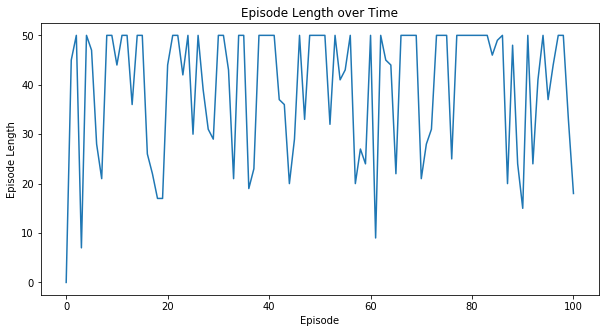

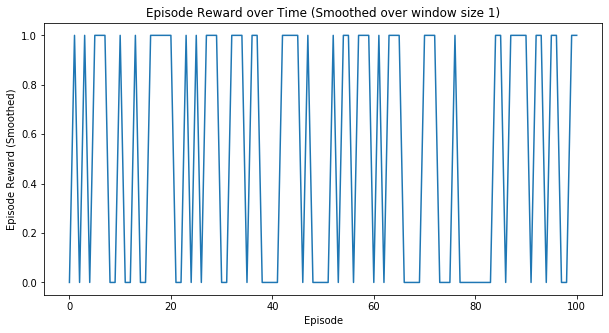

In [12]:
max_number_of_episodes = 100
env = SimpleRoomsEnv()
agent = RandomAgent(range(env.action_space.n))
experiment = Experiment(env, agent)
experiment.run_agent(max_number_of_episodes, interactive)

<Figure size 720x360 with 0 Axes>

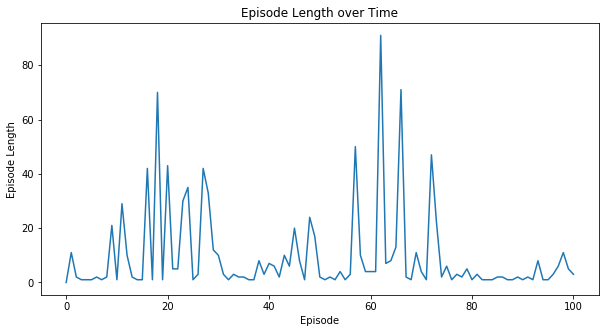

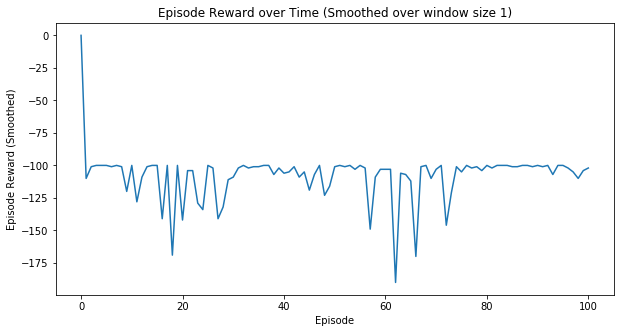

In [13]:
max_number_of_episodes = 100
env = CliffWalkingEnv()
agent = RandomAgent(range(env.action_space.n))
experiment = Experiment(env, agent)
experiment.run_agent(max_number_of_episodes, interactive)